## Import libraries

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import networkx as nx
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

## Import dataset

In [168]:
data = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')
data.shape

(282, 16)

## Remove duplicates

In [3]:
df_unique = data.drop_duplicates()
df_unique.shape

(282, 16)

## Convert time-related columns to datetime format

In [5]:
df_unique['creation_time'] = pd.to_datetime(df_unique['creation_time'])
df_unique['end_time'] = pd.to_datetime(df_unique['end_time'])
df_unique['time'] = pd.to_datetime(df_unique['time'])

## Standardize text data (e.g. convert to upper case)

In [6]:
df_unique['src_ip_country_code'] = df_unique['src_ip_country_code'].str.upper()

## Datasets Information

In [7]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  source.meta          2

In [9]:
df_unique.head(3).T

,0,1,2
bytes_in,5602,30912,28506
bytes_out,12990,18186,13468
creation_time,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00
end_time,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00
src_ip,147.161.161.82,165.225.33.6,165.225.212.255
src_ip_country_code,AE,US,CA
protocol,HTTPS,HTTPS,HTTPS
response.code,200,200,200
dst_port,443,443,443
dst_ip,10.138.69.97,10.138.69.97,10.138.69.97


## Data Transformation

1. Normalization and Scaling: Normalization or scaling ensures that numeric features contribute equally to model training. Common methods include:

* Min-Max Scaling : Transforms features to a fixed range, usually 0 to 1.
* Standardization (Z-score Scaling) : Centers the data by removing the mean and scales it by the standard deviation to achieve a variance of 1 and mean of 0.

2. Encoding Categorical Data: Machine learning models generally require all input and output variables to be numeric. This means that categorical data must be converted into a numerical format.

* One-Hot Encoding : Creates a binary column for each category and returns a matrix with 1s and 0s.
* Label Encoding : Converts each value in a column to a number.

3. Feature Engineering: Feature engineering is the process of using domain knowledge to select, modify, or create new features that increase the predictive power of the learning algorithm.

*  Polynomial Features : Derive new feature interactions.
*  Binning : Convert numerical values into categorical bins.

## Feature engineering: Calculate duration of connection

In [11]:
df_unique['duration_seconds'] = (df_unique['end_time'] - df_unique['creation_time']).dt.total_seconds()
df_unique[['end_time', 'creation_time', 'duration_seconds']].head()

,end_time,creation_time,duration_seconds
0,2024-04-25 23:10:00+00:00,2024-04-25 23:00:00+00:00,600.0
1,2024-04-25 23:10:00+00:00,2024-04-25 23:00:00+00:00,600.0
2,2024-04-25 23:10:00+00:00,2024-04-25 23:00:00+00:00,600.0
3,2024-04-25 23:10:00+00:00,2024-04-25 23:00:00+00:00,600.0
4,2024-04-25 23:10:00+00:00,2024-04-25 23:00:00+00:00,600.0


## StandardScaler for numerical features

In [15]:
df_unique[['bytes_in', 'bytes_out', 'duration_seconds']].head()

,bytes_in,bytes_out,duration_seconds
0,5602,12990,600.0
1,30912,18186,600.0
2,28506,13468,600.0
3,30546,14278,600.0
4,6526,13892,600.0


In [14]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_unique[['bytes_in', 'bytes_out', 'duration_seconds']])
scaled_features[0:5]

array([[-0.28821898, -0.28122272,  0.        ],
       [-0.28210833, -0.26080425,  0.        ],
       [-0.28268922, -0.27934434,  0.        ],
       [-0.2821967 , -0.27616133,  0.        ],
       [-0.2879959 , -0.27767817,  0.        ]])

## OneHotEncoder for categorical features

In [16]:
df_unique[['src_ip_country_code']].head()

,src_ip_country_code
0,AE
1,US
2,CA
3,US
4,NL


In [17]:
df_unique[['src_ip_country_code']].value_counts()

src_ip_country_code
US                     113
CA                      72
DE                      28
AT                      21
NL                      18
AE                      16
IL                      14
Name: count, dtype: int64

In [19]:
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_unique[['src_ip_country_code']])

In [22]:
# There are 7 labels (unique values) in feature 'src_ip_country_code' so 7 new columns created for these 7 labels
encoded_features.shape

(282, 7)

In [21]:
encoded_features[0:10]

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]])

In [23]:
df_unique[['src_ip_country_code']].head(10)

,src_ip_country_code
0,AE
1,US
2,CA
3,US
4,NL
5,CA
6,DE
7,US
8,CA
9,AT


In [24]:
encoder.categories_

[array(['AE', 'AT', 'CA', 'DE', 'IL', 'NL', 'US'], dtype=object)]

In [27]:
encoder.get_feature_names_out(['src_ip_country_code'])

array(['src_ip_country_code_AE', 'src_ip_country_code_AT',
       'src_ip_country_code_CA', 'src_ip_country_code_DE',
       'src_ip_country_code_IL', 'src_ip_country_code_NL',
       'src_ip_country_code_US'], dtype=object)

## Combining transformed features back into the DataFrame

In [28]:
scaled_columns = ['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration_seconds']
encoded_columns = encoder.get_feature_names_out(['src_ip_country_code'])

In [29]:
scaled_columns

['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration_seconds']

In [30]:
encoded_columns

array(['src_ip_country_code_AE', 'src_ip_country_code_AT',
       'src_ip_country_code_CA', 'src_ip_country_code_DE',
       'src_ip_country_code_IL', 'src_ip_country_code_NL',
       'src_ip_country_code_US'], dtype=object)

In [32]:
scaled_features[0:5]

array([[-0.28821898, -0.28122272,  0.        ],
       [-0.28210833, -0.26080425,  0.        ],
       [-0.28268922, -0.27934434,  0.        ],
       [-0.2821967 , -0.27616133,  0.        ],
       [-0.2879959 , -0.27767817,  0.        ]])

In [37]:
scaled_features.shape

(282, 3)

In [38]:
encoded_features[0:5]

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.]])

In [39]:
encoded_features.shape

(282, 7)

In [36]:
df_unique.index

RangeIndex(start=0, stop=282, step=1)

In [41]:
df_unique.head(3).T

,0,1,2
bytes_in,5602,30912,28506
bytes_out,12990,18186,13468
creation_time,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00
end_time,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00
src_ip,147.161.161.82,165.225.33.6,165.225.212.255
src_ip_country_code,AE,US,CA
protocol,HTTPS,HTTPS,HTTPS
response.code,200,200,200
dst_port,443,443,443
dst_ip,10.138.69.97,10.138.69.97,10.138.69.97


In [42]:
# Convert numpy arrays back to DataFrame

scaled_df = pd.DataFrame(scaled_features, columns=scaled_columns, index=df_unique.index)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=df_unique.index)

# Concatenate all the data back together
transformed_df = pd.concat([df_unique, scaled_df, encoded_df], axis=1)

In [44]:
scaled_df.head()

,scaled_bytes_in,scaled_bytes_out,scaled_duration_seconds
0,-0.288219,-0.281223,0.0
1,-0.282108,-0.260804,0.0
2,-0.282689,-0.279344,0.0
3,-0.282197,-0.276161,0.0
4,-0.287996,-0.277678,0.0


In [46]:
encoded_df.head().T

,0,1,2,3,4
src_ip_country_code_AE,1.0,0.0,0.0,0.0,0.0
src_ip_country_code_AT,0.0,0.0,0.0,0.0,0.0
src_ip_country_code_CA,0.0,0.0,1.0,0.0,0.0
src_ip_country_code_DE,0.0,0.0,0.0,0.0,0.0
src_ip_country_code_IL,0.0,0.0,0.0,0.0,0.0
src_ip_country_code_NL,0.0,0.0,0.0,0.0,1.0
src_ip_country_code_US,0.0,1.0,0.0,1.0,0.0


In [48]:
transformed_df.head(3).T

,0,1,2
bytes_in,5602,30912,28506
bytes_out,12990,18186,13468
creation_time,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00
end_time,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00
src_ip,147.161.161.82,165.225.33.6,165.225.212.255
src_ip_country_code,AE,US,CA
protocol,HTTPS,HTTPS,HTTPS
response.code,200,200,200
dst_port,443,443,443
dst_ip,10.138.69.97,10.138.69.97,10.138.69.97


## Exploratory Data Analysis (EDA)

* A significant stage in the process of summarizing, describing, and comprehending the underlying patterns in the data is the performing of statistical analysis. Examining several aspects such as distributions, central trends, variability, and correlations between characteristics is included in this.

1. Descriptive Statistics : This includes mean, median, mode, min, max, range, quartiles, and standard deviations.
2. Correlation Analysis : To investigate the relationships between numerical features and how they relate to each other.
3. Distribution Analysis : Examine the distribution of key features using histograms and box plots to identify the spread and presence of outliers.

## Compute correlation matrix for numeric columns only

In [51]:
numeric_df = transformed_df.select_dtypes(include=['float64', 'int64'])
numeric_df.head(3).T

,0,1,2
bytes_in,5602.000000,30912.000000,28506.000000
bytes_out,12990.000000,18186.000000,13468.000000
response.code,200.000000,200.000000,200.000000
dst_port,443.000000,443.000000,443.000000
duration_seconds,600.000000,600.000000,600.000000
scaled_bytes_in,-0.288219,-0.282108,-0.282689
scaled_bytes_out,-0.281223,-0.260804,-0.279344
scaled_duration_seconds,0.000000,0.000000,0.000000
src_ip_country_code_AE,1.000000,0.000000,0.000000
src_ip_country_code_AT,0.000000,0.000000,0.000000


In [61]:
correlation_matrix_numeric = numeric_df.corr()

In [62]:
correlation_matrix_numeric.shape

(15, 15)

In [63]:
correlation_matrix_numeric.iloc[:, :8]

,bytes_in,bytes_out,response.code,dst_port,duration_seconds,scaled_bytes_in,scaled_bytes_out,scaled_duration_seconds
bytes_in,1.000000,0.997705,NaN,NaN,NaN,1.000000,0.997705,NaN
bytes_out,0.997705,1.000000,NaN,NaN,NaN,0.997705,1.000000,NaN
response.code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dst_port,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration_seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scaled_bytes_in,1.000000,0.997705,NaN,NaN,NaN,1.000000,0.997705,NaN
scaled_bytes_out,0.997705,1.000000,NaN,NaN,NaN,0.997705,1.000000,NaN
scaled_duration_seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src_ip_country_code_AE,-0.070559,-0.072452,NaN,NaN,NaN,-0.070559,-0.072452,NaN
src_ip_country_code_AT,-0.081670,-0.081777,NaN,NaN,NaN,-0.081670,-0.081777,NaN


In [71]:
correlation_matrix_numeric.iloc[:, 8:12]

,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE
bytes_in,-0.070559,-0.081670,-0.166488,-0.095333
bytes_out,-0.072452,-0.081777,-0.159587,-0.090001
response.code,NaN,NaN,NaN,NaN
dst_port,NaN,NaN,NaN,NaN
duration_seconds,NaN,NaN,NaN,NaN
scaled_bytes_in,-0.070559,-0.081670,-0.166488,-0.095333
scaled_bytes_out,-0.072452,-0.081777,-0.159587,-0.090001
scaled_duration_seconds,NaN,NaN,NaN,NaN
src_ip_country_code_AE,1.000000,-0.069568,-0.143607,-0.081429
src_ip_country_code_AT,-0.069568,1.000000,-0.166091,-0.094178


In [72]:
correlation_matrix_numeric.iloc[:, 12:15]

,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
bytes_in,-0.065939,-0.006827,0.316015
bytes_out,-0.067630,-0.045641,0.327683
response.code,NaN,NaN,NaN
dst_port,NaN,NaN,NaN
duration_seconds,NaN,NaN,NaN
scaled_bytes_in,-0.065939,-0.006827,0.316015
scaled_bytes_out,-0.067630,-0.045641,0.327683
scaled_duration_seconds,NaN,NaN,NaN
src_ip_country_code_AE,-0.056055,-0.064040,-0.200546
src_ip_country_code_AT,-0.064831,-0.074067,-0.231945


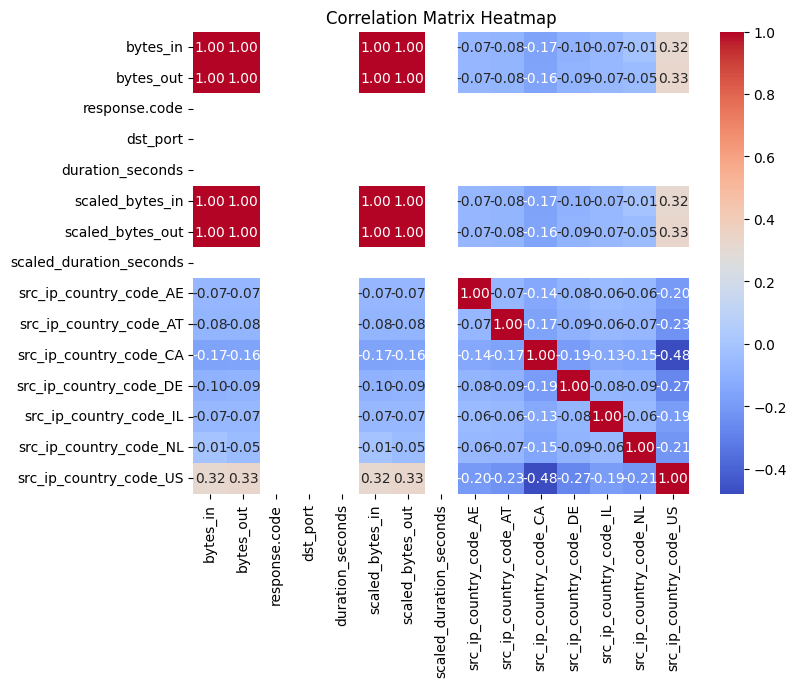

In [75]:
# Heatmap for the correlation matrix

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_numeric, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

## Stacked Bar Chart for Detection Types by Country

In [76]:
transformed_df[['src_ip_country_code', 'detection_types']].head()

,src_ip_country_code,detection_types
0,AE,waf_rule
1,US,waf_rule
2,CA,waf_rule
3,US,waf_rule
4,NL,waf_rule


In [77]:
detection_types_by_country = pd.crosstab(transformed_df['src_ip_country_code'], transformed_df['detection_types'])
detection_types_by_country

detection_types,waf_rule
src_ip_country_code,
AE,16
AT,21
CA,72
DE,28
IL,14
NL,18
US,113


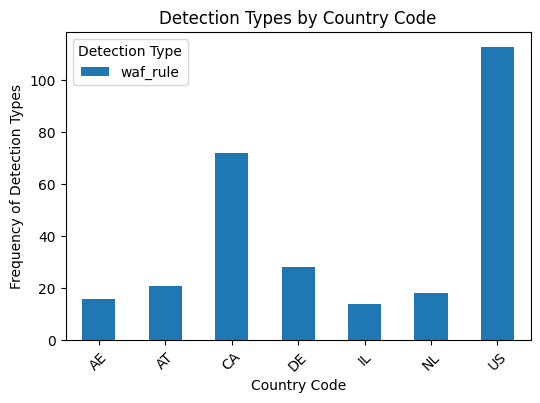

In [84]:
detection_types_by_country.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title('Detection Types by Country Code')
plt.xlabel('Country Code')
plt.ylabel('Frequency of Detection Types')
plt.xticks(rotation=45)
plt.legend(title='Detection Type')
plt.show()

In [83]:
# Understand crosstab from simple data

crosstab_data = {'src_ip_country_code_crosstab': ['US', 'IN', 'US', 'CA', 'IN', 'US', 'CA'],
        'detection_types_crosstab': ['Malware', 'Phishing', 'Intrusion', 'Malware', 'Malware', 'Phishing', 'Phishing']}

transformed_df_crosstab_data = pd.DataFrame(crosstab_data)

print(transformed_df_crosstab_data)
print('\n\n')

detection_types_by_country_crosstab_data = pd.crosstab(transformed_df_crosstab_data['src_ip_country_code_crosstab'], transformed_df_crosstab_data['detection_types_crosstab'])
print(detection_types_by_country_crosstab_data)

  src_ip_country_code_crosstab detection_types_crosstab
0                           US                  Malware
1                           IN                 Phishing
2                           US                Intrusion
3                           CA                  Malware
4                           IN                  Malware
5                           US                 Phishing
6                           CA                 Phishing



detection_types_crosstab      Intrusion  Malware  Phishing
src_ip_country_code_crosstab                              
CA                                    0        1         1
IN                                    0        1         1
US                                    1        1         1


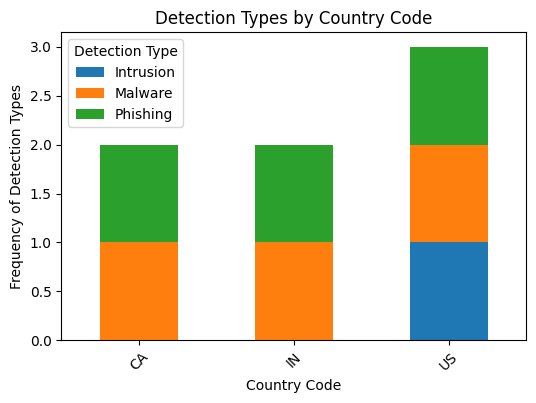

In [85]:
detection_types_by_country_crosstab_data.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title('Detection Types by Country Code')
plt.xlabel('Country Code')
plt.ylabel('Frequency of Detection Types')
plt.xticks(rotation=45)
plt.legend(title='Detection Type')
plt.show()

## Web Traffic Analysis Over Time

In [107]:
data_date_series = data.copy()
data_date_series.shape

(282, 16)

In [111]:
data_date_series['creation_time'] = pd.to_datetime(data_date_series['creation_time'])
data_date_series['end_time'] = pd.to_datetime(data_date_series['end_time'])
data_date_series['time'] = pd.to_datetime(data_date_series['time'])

In [112]:
data_date_series['creation_time'] = data_date_series['creation_time'].dt.date
data_date_series['end_time'] = data_date_series['end_time'].dt.date
data_date_series['time'] = data_date_series['time'].dt.date

In [113]:
data_date_series.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25,2024-04-25,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25,waf_rule
1,30912,18186,2024-04-25,2024-04-25,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25,waf_rule
2,28506,13468,2024-04-25,2024-04-25,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25,waf_rule
3,30546,14278,2024-04-25,2024-04-25,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25,waf_rule
4,6526,13892,2024-04-25,2024-04-25,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25,waf_rule


In [116]:
# Set 'creation_time' as the index
data_date_series.set_index('creation_time', inplace=True)
data_date_series.head()

,bytes_in,bytes_out,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
creation_time,,,,,,,,,,,,,,,
2024-04-25,5602,12990,2024-04-25,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25,waf_rule
2024-04-25,30912,18186,2024-04-25,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25,waf_rule
2024-04-25,28506,13468,2024-04-25,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25,waf_rule
2024-04-25,30546,14278,2024-04-25,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25,waf_rule
2024-04-25,6526,13892,2024-04-25,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25,waf_rule


In [121]:
data_date_series.index

Index([2024-04-25, 2024-04-25, 2024-04-25, 2024-04-25, 2024-04-25, 2024-04-25,
       2024-04-25, 2024-04-25, 2024-04-25, 2024-04-25,
       ...
       2024-04-26, 2024-04-26, 2024-04-26, 2024-04-26, 2024-04-26, 2024-04-26,
       2024-04-26, 2024-04-26, 2024-04-26, 2024-04-26],
      dtype='object', name='creation_time', length=282)

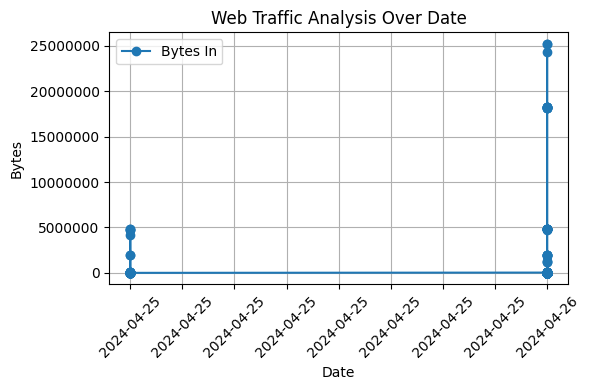

In [132]:
plt.figure(figsize=(6, 4))
plt.plot(data_date_series.index, data_date_series['bytes_in'], label='Bytes In', marker='o')
plt.title('Web Traffic Analysis Over Date')
plt.xlabel('Date')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)

# Format the x-axis to show only the date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Format the y-axis to disable scientific notation
formatter = ticker.ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

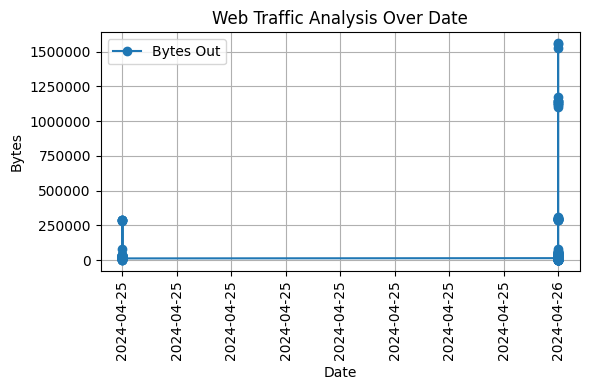

In [134]:
plt.figure(figsize=(6, 4))
plt.plot(data_date_series.index, data_date_series['bytes_out'], label='Bytes Out', marker='o')
plt.title('Web Traffic Analysis Over Date')
plt.xlabel('Date')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)

# Format the x-axis to show only the date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)

# Format the y-axis to disable scientific notation
formatter = ticker.ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [123]:
data_date_series.index.max()

datetime.date(2024, 4, 26)

In [124]:
data_date_series.index.min()

datetime.date(2024, 4, 25)

In [125]:
data_date_series.index.value_counts()

creation_time
2024-04-26    224
2024-04-25     58
Name: count, dtype: int64

## Network Interaction between Source IPs and Destination IPs

In [135]:
G = nx.Graph()

In [136]:
# Add edges from source IP to destination IP
for idx, row in data.iterrows():
    G.add_edge(row['src_ip'], row['dst_ip'])

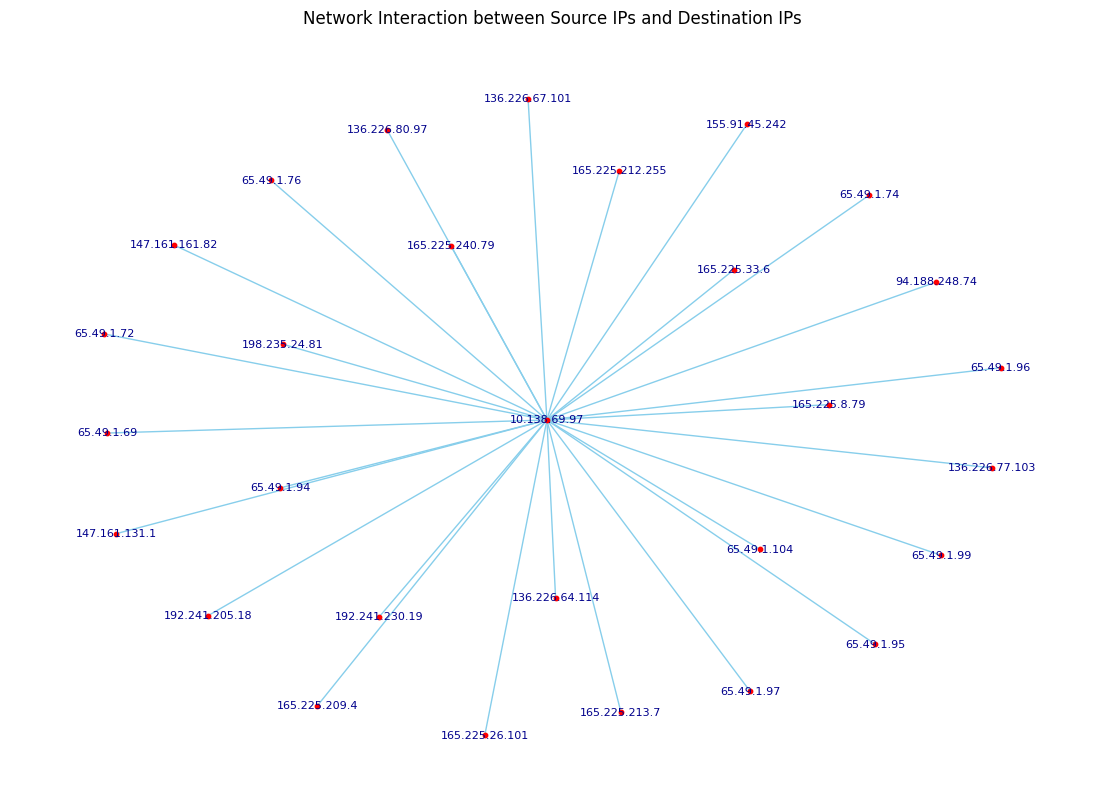

In [143]:
# Draw the network graph

plt.figure(figsize=(14, 10))
nx.draw_networkx(G, with_labels=True, node_size=10, node_color='red', font_size=8, font_color='darkblue', edge_color='skyblue')
plt.title('Network Interaction between Source IPs and Destination IPs')
plt.axis('off')
plt.show()

## RandomForestClassifier

## Feature engineering: 'is_suspicious' column as binary labels

In [144]:
transformed_df.head().T

,0,1,2,3,4
bytes_in,5602,30912,28506,30546,6526
bytes_out,12990,18186,13468,14278,13892
creation_time,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00
end_time,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00
src_ip,147.161.161.82,165.225.33.6,165.225.212.255,136.226.64.114,165.225.240.79
src_ip_country_code,AE,US,CA,US,NL
protocol,HTTPS,HTTPS,HTTPS,HTTPS,HTTPS
response.code,200,200,200,200,200
dst_port,443,443,443,443,443
dst_ip,10.138.69.97,10.138.69.97,10.138.69.97,10.138.69.97,10.138.69.97


In [145]:
transformed_df['detection_types'].value_counts()

detection_types
waf_rule    282
Name: count, dtype: int64

In [146]:
transformed_df['detection_types'] == 'waf_rule'

0      True
1      True
2      True
3      True
4      True
       ... 
277    True
278    True
279    True
280    True
281    True
Name: detection_types, Length: 282, dtype: bool

In [147]:
(transformed_df['detection_types'] == 'waf_rule').astype(int)

0      1
1      1
2      1
3      1
4      1
      ..
277    1
278    1
279    1
280    1
281    1
Name: detection_types, Length: 282, dtype: int32

In [148]:
transformed_df['is_suspicious'] = (transformed_df['detection_types'] == 'waf_rule').astype(int)
transformed_df['is_suspicious'].head()

0    1
1    1
2    1
3    1
4    1
Name: is_suspicious, dtype: int32

In [149]:
transformed_df.head().T

,0,1,2,3,4
bytes_in,5602,30912,28506,30546,6526
bytes_out,12990,18186,13468,14278,13892
creation_time,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00
end_time,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00,2024-04-25 23:10:00+00:00
src_ip,147.161.161.82,165.225.33.6,165.225.212.255,136.226.64.114,165.225.240.79
src_ip_country_code,AE,US,CA,US,NL
protocol,HTTPS,HTTPS,HTTPS,HTTPS,HTTPS
response.code,200,200,200,200,200
dst_port,443,443,443,443,443
dst_ip,10.138.69.97,10.138.69.97,10.138.69.97,10.138.69.97,10.138.69.97


## Make features (X) and the target variable (y)

In [150]:
# Features and Labels
# Numeric features
X = transformed_df[['bytes_in', 'bytes_out', 'scaled_duration_seconds']]
# Binary labels
y = transformed_df['is_suspicious']

In [151]:
X.head()

,bytes_in,bytes_out,scaled_duration_seconds
0,5602,12990,0.0
1,30912,18186,0.0
2,28506,13468,0.0
3,30546,14278,0.0
4,6526,13892,0.0


In [152]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: is_suspicious, dtype: int32

## Split the data into training and test sets

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [154]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(197, 3)
(85, 3)
(197,)
(85,)


In [155]:
X_train.head()

,bytes_in,bytes_out,scaled_duration_seconds
178,5238,11674,0.0
55,10768,7248,0.0
111,28048,4730,0.0
217,4704,11882,0.0
38,4220,11672,0.0


In [156]:
X_test.head()

,bytes_in,bytes_out,scaled_duration_seconds
92,5238,11674,0.0
93,9052,5162,0.0
179,4480,11778,0.0
124,10012,14968,0.0
261,8052,13298,0.0


In [157]:
y_train.head()

178    1
55     1
111    1
217    1
38     1
Name: is_suspicious, dtype: int32

In [158]:
y_test.head()

92     1
93     1
179    1
124    1
261    1
Name: is_suspicious, dtype: int32

## Initialize the Random Forest Classifier

In [159]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier

RandomForestClassifier(random_state=42)

## Train the model

In [160]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Predict on the test set

In [162]:
y_pred = rf_classifier.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Evaluate the model

In [163]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

1.0

In [165]:
classification = classification_report(y_test, y_pred)
print(classification)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



## Neural Network

In [169]:
data_neural = data.copy()
data_neural.shape

(282, 16)

In [170]:
data_neural.head().T

,0,1,2,3,4
bytes_in,5602,30912,28506,30546,6526
bytes_out,12990,18186,13468,14278,13892
creation_time,2024-04-25T23:00:00Z,2024-04-25T23:00:00Z,2024-04-25T23:00:00Z,2024-04-25T23:00:00Z,2024-04-25T23:00:00Z
end_time,2024-04-25T23:10:00Z,2024-04-25T23:10:00Z,2024-04-25T23:10:00Z,2024-04-25T23:10:00Z,2024-04-25T23:10:00Z
src_ip,147.161.161.82,165.225.33.6,165.225.212.255,136.226.64.114,165.225.240.79
src_ip_country_code,AE,US,CA,US,NL
protocol,HTTPS,HTTPS,HTTPS,HTTPS,HTTPS
response.code,200,200,200,200,200
dst_port,443,443,443,443,443
dst_ip,10.138.69.97,10.138.69.97,10.138.69.97,10.138.69.97,10.138.69.97


In [171]:
data_neural['is_suspicious'] = (data_neural['detection_types'] == 'waf_rule').astype(int)

In [172]:
data_neural.head().T

,0,1,2,3,4
bytes_in,5602,30912,28506,30546,6526
bytes_out,12990,18186,13468,14278,13892
creation_time,2024-04-25T23:00:00Z,2024-04-25T23:00:00Z,2024-04-25T23:00:00Z,2024-04-25T23:00:00Z,2024-04-25T23:00:00Z
end_time,2024-04-25T23:10:00Z,2024-04-25T23:10:00Z,2024-04-25T23:10:00Z,2024-04-25T23:10:00Z,2024-04-25T23:10:00Z
src_ip,147.161.161.82,165.225.33.6,165.225.212.255,136.226.64.114,165.225.240.79
src_ip_country_code,AE,US,CA,US,NL
protocol,HTTPS,HTTPS,HTTPS,HTTPS,HTTPS
response.code,200,200,200,200,200
dst_port,443,443,443,443,443
dst_ip,10.138.69.97,10.138.69.97,10.138.69.97,10.138.69.97,10.138.69.97


In [173]:
X = data_neural[['bytes_in', 'bytes_out']].values
y = data_neural['is_suspicious'].values

In [176]:
X[0:5]

array([[ 5602, 12990],
       [30912, 18186],
       [28506, 13468],
       [30546, 14278],
       [ 6526, 13892]], dtype=int64)

In [177]:
y[0:5]

array([1, 1, 1, 1, 1])

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [179]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(197, 2)
(85, 2)
(197,)
(85,)


In [182]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [183]:
X_train_scaled[0:5]

array([[-0.29837288, -0.29613633],
       [-0.29711167, -0.31250655],
       [-0.29317068, -0.32181974],
       [-0.29849467, -0.29536701],
       [-0.29860506, -0.29614373]])

In [184]:
X_test_scaled[0:5]

array([[-0.29837288, -0.29613633],
       [-0.29750304, -0.32022192],
       [-0.29854576, -0.29575167],
       [-0.29728409, -0.28395298],
       [-0.2977311 , -0.29012973]])

In [185]:
# Neural network model

model = Sequential(
    [
        Dense(8, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

In [186]:
# Compile the model
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [187]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=8, verbose=1)
history

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8891 - loss: 0.6936
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.6042
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.5242
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.4489
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.3787
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.3271
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.2709
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.2233
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1751
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1210


In [188]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0889
Test Accuracy: 100.00%


## Neural network model

In [189]:
model = Sequential(
    [
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ]
)

In [190]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [191]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.7599 - loss: 0.6607 - val_accuracy: 1.0000 - val_loss: 0.5778
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.5794 - val_accuracy: 1.0000 - val_loss: 0.4983
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.4951 - val_accuracy: 1.0000 - val_loss: 0.4178
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.4230 - val_accuracy: 1.0000 - val_loss: 0.3350
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.3445 - val_accuracy: 1.0000 - val_loss: 0.2540
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.2672 - val_accuracy: 1.0000 - val_loss: 0.1800
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1915 - val_accuracy: 1.0000 - val_loss: 0.1200
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.1339 - val_accuracy: 1.0000 - val_loss: 0.0767

In [192]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0361
Test Accuracy: 100.00%


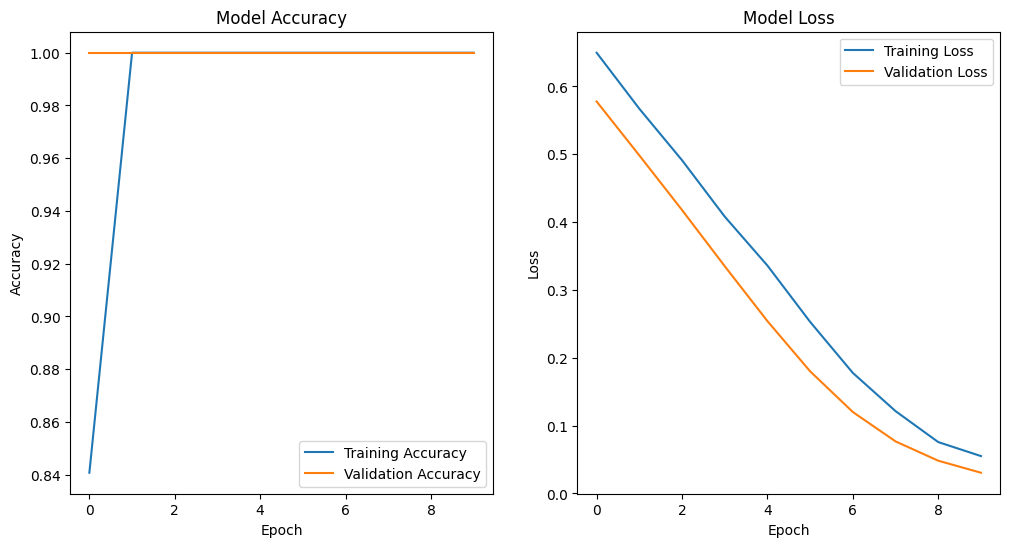

In [193]:
# Plotting the training history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [194]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [196]:
X_train_scaled[0:5]

array([[-0.29837288, -0.29613633],
       [-0.29711167, -0.31250655],
       [-0.29317068, -0.32181974],
       [-0.29849467, -0.29536701],
       [-0.29860506, -0.29614373]])

In [197]:
X_test_scaled[0:5]

array([[-0.29837288, -0.29613633],
       [-0.29750304, -0.32022192],
       [-0.29854576, -0.29575167],
       [-0.29728409, -0.28395298],
       [-0.2977311 , -0.29012973]])

In [198]:
# Adjusting the network to accommodate the input size

model = Sequential(
    [
        Conv1D(32, kernel_size=1, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ]
)

In [199]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [200]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)
history

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.3909 - loss: 0.6897 - val_accuracy: 1.0000 - val_loss: 0.6224
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8574 - loss: 0.6486 - val_accuracy: 1.0000 - val_loss: 0.5800
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9966 - loss: 0.6166 - val_accuracy: 1.0000 - val_loss: 0.5453
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.5641 - val_accuracy: 1.0000 - val_loss: 0.5143
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.5424 - val_accuracy: 1.0000 - val_loss: 0.4832
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.5153 - val_accuracy: 1.0000 - val_loss: 0.4493
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.4727 - val_accuracy: 1.0000 - val_loss: 0.4099
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.4340 - val_accuracy: 1.0000 - val_loss: 0.3669

In [201]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.2931
Test Accuracy: 100.00%


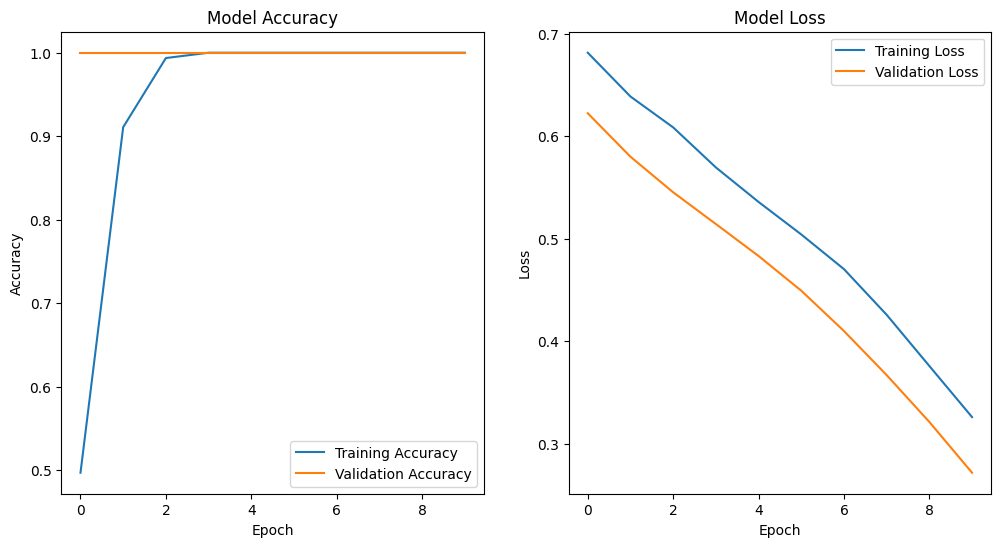

In [203]:
# Plotting the training history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()